[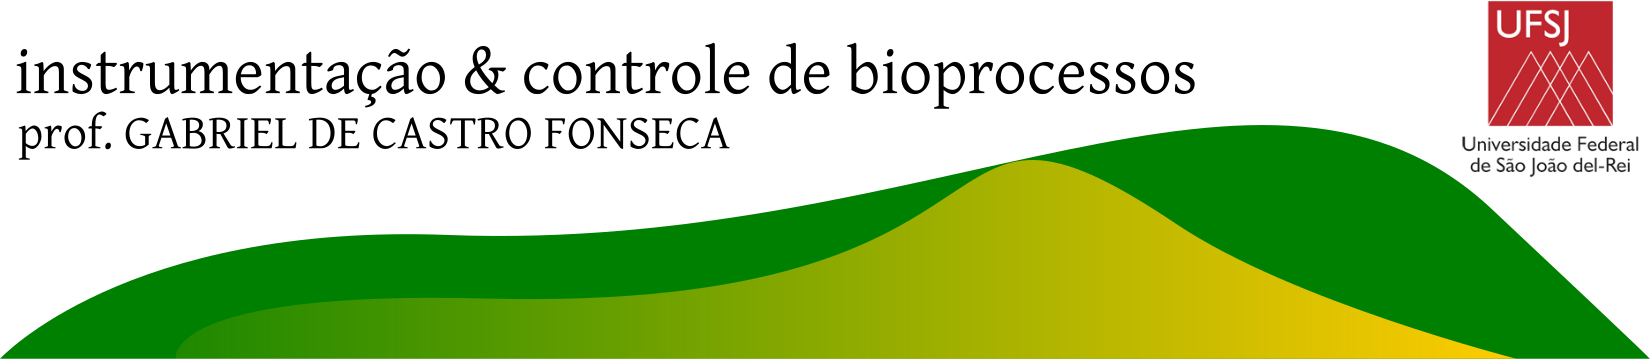](Aulas-Sumário.ipynb)

# Sistemas de Primeira Ordem II

*Prof. Gabriel de Castro Fonseca (DQBIO/UFSJ)*<br>
*Instrumentação e Controle de Bioprocessos*

Este documento é publicado sob os termos da licença [GNU General Public Licence 3.0](https://www.gnu.org/licenses/gpl-3.0.en.html).

## Estímulos deslocados no tempo

O balanço de energia em um forno a temperatura $T$ que é aquecido por uma fonte de calor $q$ e perde calor para o ambiente por convecção pode ser escrito como

\begin{gather*}
    mc_p\frac{dT}{dt} = q - hA(T-T_{amb}) \\
    \frac{mc_p}{hA}\frac{dT}{dt} + T = \frac{1}{hA}q(t) + T_{amb}(t)\\
    \tau \frac{dy}{dt} + y = K_1 u_1 + K_2 u_2
\end{gather*}

O modelo é de primeira ordem e do tipo capacitivo. Observe, porém, que diferentemente dos modelos que escrevemos [na última aula](primeira_ordem1.ipynb), este é afetado por dois estímulos. Como o sistema é linear, os dois estímulos são independentes um do outro. Pode-se resolver o problema considerando um estímulo de cada vez e depois somar as soluções.

Uma forma mais geral de representar um sistema capacitivo seria

\begin{equation}
    \tau \frac{dy}{dt} + y = \sum_i K_i u_i(t)
\end{equation}

Se há um único estímulo no sistema, por convenção consideramos que o momento do estímulo é o tempo $t=0$. No entanto, se um sistema pode ser afetado por diferentes estímulos, nada garante que eles vão acontecer ao mesmo tempo. Por exemplo, o calor fornecido para um forno pode aumentar por um degrau e dez minutos depois a temperatura ambiente pode começar a cair em forma de rampa.

A função degrau unitário $\mathbf{1}^+(t)$ é definida com valor de um quando $t\geq 0$ e zero quando $t<0$. Para mudar o tempo do degrau de zero para um valor arbitrário $\theta$ basta mudar o argumento da função para $t-\theta$, de forma que $t=\theta\implies\mathbf{1}^+(0)$. Ou seja:

\begin{equation}
    \mathbf{1}^+(t-\theta) = \left\{ 
        \begin{array}{cl}
            0, & t < \theta \\
            1, & t \geq \theta
        \end{array}
    \right.
\end{equation}

A resposta de um sistema capacitivo a um degrau $u(t) = a\mathbf{1}^+(t)$ é

$$y(t) = aK(1-e^{-t/\tau})\mathbf{1}^+(t)$$ 

Vejamos como esse sistema responde a um degrau atrasado no tempo, $u(t) = a\mathbf{1}^+(t-\theta)$:

$$ 
    \tau \frac{dy}{dt} + y = K \cdot a\mathbf{1}^+(t-\theta)
$$

A solução homogênea não depende do estímulo e é sempre a mesma para sistemas capacitivos: $y_H = Ce^{-t/\tau}$.

A solução particular para um degrau de magnitude $a$ no tempo $\theta$ é outro degrau de magnitude $A$ no tempo $\theta$, ou seja, $t<\theta\implies y_P(t) = 0$ e para $t\geq\theta$, $y_P(t) = A$. Substituindo na EDO,

\begin{gather*}
    \tau \frac{d0}{dt} + 0 = aK \cdot 0\;,\quad t < \theta \\
    \tau \frac{dA}{dt} + A = aK \cdot 1\;,\quad t \geq \theta \\
    y_P(t) = aK\cdot\mathbf{1}^+(t-\theta)
\end{gather*}

A solução geral é $y(t) = y_H(t) + y_P(t)$ e deve respeitar a condição inicial $y(\theta) = 0$. Repare que a aplicação da condição inicial é extremamente importante para resolver corretamente este problema. No instante do degrau, o sistema ainda não teve tempo para responder, por isso o desvio na variável resposta é nulo.

Para $t\geq \theta$:
\begin{gather*}
    y(t) = Ce^{-t/\tau} + aK \\
    y(\theta) = Ce^{-\theta/\tau} + aK = 0 \\
    C = -aKe^{+\theta/\tau} \\
    y(t) = -aKe^{(-t+\theta)/\tau}+aK
\end{gather*}

A solução é

\begin{equation}
    y(t) = aK\left[ 1 - e^{-(t-\theta)/\tau} \right] \mathbf{1}^+(t-\theta)
\end{equation}

Observe que a resposta a um degrau no tempo $\theta$ é apenas um translação da resposta para um degrau no tempo $0$. Poderíamos facilmente encontrar a resposta fazendo a substituição de variáveis $ t \leftarrow (t-\theta) $. 

A resposta a um estímulo rampa, por exemplo, seria

\begin{gather}
    u(t) = at\cdot\mathbf{1}^+(t) \quad \implies \quad y(t) = aK\left(e^{-t/\tau} + \frac{t}{\tau}-1\right)\mathbf{1}^+(t) \\
    u(t) = at\cdot\mathbf{1}^+(t-\theta) \quad \implies \quad y(t) = aK\left(e^{-(t-\theta)/\tau} + \frac{t-\theta}{\tau}-1\right)\mathbf{1}^+(t-\theta) \\
\end{gather}

No programa abaixo você pode variar o valor de $\theta$ para acompanhar o que acontece com as respostas ao degrau e à rampa no sistema capacitivo e integrador.

In [1]:
%matplotlib inline

# Carregando pacotes
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Função principal
def principal(tipo,estímulo,θ):
    """
    Função que executa operações principais do programa. Chamada pelo botão "Simular".
    """
    t = np.linspace(-2,10,151) # vetor dos tempos
    
    u0, y0, texto = resposta(tipo,estímulo,t)
    u, y, _ = resposta(tipo,estímulo,t,θ)
    
    graf0(t,u0,y0,u,y, texto)
    
    
def estim(nucleo,t,θ=0):
    """
    Estrutura comum dos estimulos. 
    """
    tipo = type(t)
    if tipo in [int,float]:
        return nucleo if t > θ else 0
    elif tipo == np.ndarray:
        return np.where( t > θ, nucleo, 0 )
    else:
        return None 

def resposta(tipo,estímulo,t,θ=0):
    """
    Resposta ao degrau.
    """
    if estímulo == 'degrau':
        u = estim(1,t,θ)
        if tipo == "integrador":
            y = np.where( t > θ, t-θ, 0 )
            texto = [r'$u(t) = a\mathbf{1}^+(t-\theta)$', r"$y(t) = ak(t-\theta)\mathbf{1}^+(t-\theta)$"]
        else:
            y = np.where( t > θ, 1 - np.exp(-t+θ) , 0 )
            texto = [r'$u(t) = a\mathbf{1}^+(t-\theta)$', r"$y(t) = aK(1-e^{-(t-\theta)/\tau})\mathbf{1}^+(t-\theta)$"]
    if estímulo == 'rampa':
        u = estim(t-θ,t,θ)
        if tipo == "integrador":
            y = np.where( t > θ, (t-θ)**2/2, 0 )
            texto = [r'$u(t) = at\mathbf{1}^+(t-\theta)$', r"$y(t) = ak\dfrac{(t-\theta)^2}{2}\mathbf{1}^+(t-\theta)$"]
        else:
            y = np.where( t > θ, np.exp(-t+θ)+(t-θ)-1 , 0 )
            texto = [r'$u(t) = at\mathbf{1}^+(t-\theta)$', r"$y(t) = aK\left[e^{-(t-\theta)/\tau}+\dfrac{t-\theta}{\tau}-1\right]\mathbf{1}^+(t-\theta)$"]
    return u, y, texto

def graf0(t,u0,y0,u,y,texto):
    plt.rcParams["figure.figsize"]=[15,6]
    plt.rcParams.update({'font.size': 14})
    
    plt.subplot(1,2,1)
    plt.plot(t,u0,color="grey",linestyle="--")
    plt.plot(t,u)
    plt.ylabel("Estímulo, $u(t)$")
    plt.xlabel(r"Tempo, $\dfrac{t}{\tau}$")
    plt.title(texto[0]+'\n')
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(t,y)
    plt.plot(t,y0,color="grey",linestyle="--")
    plt.ylabel(r"Resposta, $\dfrac{y(t)}{aK}$")
    plt.xlabel(r"Tempo, $\dfrac{t}{\tau}$")
    plt.title(texto[1]+'\n')
    plt.grid()

# Botões para interação
tipo_widget = widgets.RadioButtons(options=["capacitivo","integrador"],description="Sistema:")
u_widget = widgets.RadioButtons(options=["degrau","rampa"],value="degrau",description="Estímulo")
θ_widget = widgets.FloatSlider(min=-2.0, max=4.0, step=0.5, value=0.0, description = r'$\theta$')

w = widgets.interact_manual(principal, tipo=tipo_widget, estímulo=u_widget,θ=θ_widget)
w.widget.children[-2].description="Simular" # Muda nome do botão
w.widget.children[-1].layout.height = '450px' # mantém tamanho da área de resposta fixo
display(w)

interactive(children=(RadioButtons(description='Sistema:', options=('capacitivo', 'integrador'), value='capaci…

<function __main__.principal(tipo, estímulo, θ)>

## Pulso e impulso

A concentração de um reagente $A$ em um tanque agitado ideal pode ser modelada pela equação

\begin{equation}
    \frac{dC_A}{dt} = \frac{F_0}{V}(C_{A0}-C_A) + r_A
\end{equation}

Um experimento que pode ser realizado para verificar se as condições de mistura em um reator industrial estão próximas da idealidade consiste em injetar no sistema uma pequena quantidade de uma substância inerte chamada de traçador. Um instrumento mede a concentração de traçador que abandona o reator ao longo do tempo e a compara à curva que seria esperada de um reator ideal.

O balanço de traçador em um tanque bem misturado pode ser escrito como

\begin{gather*}
    \frac{dC_T}{dt} = \frac{F_0}{V}(C_{T0}-C_T) \\
    \frac{V}{F_0} \frac{dC_T}{dt} + C_T = C_{T0} \\
    \tau \frac{dy}{dt} + y = K u
\end{gather*}

Imagine que o traçador foi injetado com uma seringa na alimentação de um reator de laboratório. Inicialmente a concentração de traçador na alimentação é zero, depois sobe para um valor $C_T0$ e quando o conteúdo da seringa acaba a concentração volta a zero.

Esse tipo de estímulo é conhecido como um **pulso**. O pulso equivale a um degrau no tempo $t=0$ seguido por outro degrau de magnitude igual e sentido contrário no tempo $\theta$.

Um pulso desenhado sobre um gráfico teria forma retangular. A base do pulso corresponde a $\theta$, sua duração. Por definição, a área do retângulo é igual à sua magnitude $a$. O **pulso unitário** é um pulso de magnitude $a=1$. Isso significa que a altura de um pulso unitário equivale a $\;\dfrac{1}{\theta}$.

\begin{gather}
    p(t,\theta) = \frac{\mathbf{1}^+(t)-\mathbf{1}^+(t-\theta)}{\theta} \\
    p(t,\theta) = \left\{ 
        \begin{array}{cl}
            0, & t < 0 \\
            \dfrac{1}{\theta}, & 0 \leq t < \theta \\
            0, & t \geq \theta
        \end{array}
    \right.
\end{gather}

In [2]:
%matplotlib inline

def principal(a,θ):
    t = np.linspace(-2,6,101) # vetor dos tempos
    u = (estim(a,t) - estim(a,t,θ))/θ
    u0 = estim(1,t) - estim(1,t,1)
    
    plt.rcParams["figure.figsize"]=[8,6]
    plt.rcParams.update({'font.size': 14})
    
    plt.plot(t,u0,color="grey",linestyle="--")
    plt.plot(t,u)
    plt.ylabel("Estímulo, $u(t)$")
    plt.xlabel("Tempo, $t$")
    plt.grid()

# Botões para interação
a_widget = widgets.FloatSlider(min=0.5, max=2.0, step=0.1, value=1.0, description = r'$a$')
θ_widget = widgets.FloatSlider(min=0.1, max=3.05, step=0.1, value=1.0, description = r'$\theta$')

w = widgets.interact_manual(principal, a=a_widget,θ=θ_widget)
w.widget.children[-2].description="Simular" # Muda nome do botão
w.widget.children[-1].layout.height = '400px' # mantém tamanho da área de resposta fixo
display(w)

interactive(children=(FloatSlider(value=1.0, description='$a$', max=2.0, min=0.5), FloatSlider(value=1.0, desc…

<function __main__.principal(a, θ)>

Como o pulso equivale a dois degraus em sentidos contrários, o efeito do pulso sobre um sistema capacitivo pode ser calculado simplesmente somando as respostas do sistema a cada degrau isoladamente.

Para o primeiro degrau, de magnitude $\;\dfrac{a}{\theta}$ no tempo $t=0$, 

$$ y_1(t) = \frac{aK}{\theta}\left(1-e^{-t/\tau}\right)\mathbf{1}^+(t) $$

Para o segundo degrau, de magnitude $\;-\dfrac{a}{\theta}$ no tempo $t=\theta$, 

$$ y_2(t) = \frac{aK}{\theta}\left[1-e^{-(t-\theta)/\tau}\right]\mathbf{1}^+(t-\theta) $$

A resposta capacitiva ao pulso seria igual à soma $y(t) = y_1(t) + y_2(t)$.

\begin{equation}
    y(t) = \frac{aK}{\theta}\left[(1-e^{-t/\tau})\mathbf{1}^+(t) - \left(1-e^{-(t-\theta)/\tau}\right)\mathbf{1}^+(t-\theta)\right]
\end{equation}

Escrevendo por partes teríamos

\begin{equation}
    y(t) = \left\{ 
        \begin{array}{cl}
            0, & t < 0 \\
            \frac{aK}{\theta}(1-e^{-t/\tau}), & 0 \leq t < \theta \\
            \frac{aK}{\theta}(e^{-(t-\theta)/\tau}-e^{-t/\tau}), & t \geq \theta
        \end{array}
    \right.
\end{equation}

In [3]:
%matplotlib inline

def principal(θ):
    t = np.linspace(-2,8,151) # vetor dos tempos
    u = (estim(1,t) - estim(1,t,θ))/θ
    y = rpulso(t,θ)
    z = rimpulso(t)
    graf1(t,u,y,z)

def rpulso(t,θ):
    return 1/θ * np.where( t < 0, 0, np.where( t < θ, 1-np.exp(-t), np.exp(-t+θ)-np.exp(-t) ) )

def rimpulso(t):
    return np.where( t < 0, 0, np.exp(-t) )

def graf1(t,u,y,z):
    plt.rcParams["figure.figsize"]=[15,6]
    plt.rcParams.update({'font.size': 14})
    
    plt.subplot(1,2,1)
    #plt.plot(t,u0,color="grey",linestyle="--")
    plt.plot(t,u)
    plt.ylabel("Estímulo, $u(t)$")
    plt.xlabel(r"Tempo, $\dfrac{t}{\tau}$")
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(t,y)
    plt.plot(t,z,color="grey",linestyle="--")
    plt.ylabel(r"Resposta, $\dfrac{y(t)}{aK}$")
    plt.xlabel(r"Tempo, $\dfrac{t}{\tau}$")
    plt.grid()

# Botões para interação
θ_widget = widgets.FloatSlider(min=0.1, max=4.05, step=0.3, value=1.0, description = r'$\theta$')

w = widgets.interact(principal, θ=θ_widget)
w.widget.children[-1].layout.height = '400px' # mantém tamanho da área de resposta fixo
display(w)

interactive(children=(FloatSlider(value=1.0, description='$\\theta$', max=4.05, min=0.1, step=0.3), Output()),…

<function __main__.principal(θ)>

### Impulso

O **impulso** é definido como o limite quando a duração de um pulso tende a zero. É equivalente à função Delta de Dirac, $\delta(t)$, e tem as seguintes propriedades:

\begin{gather}
    \delta(t)=\frac{d}{dt}\mathbf{1}^+(t) \\
    \int_{-\infty}^\infty \delta(t) dt = 1
\end{gather}

Como pode-se observar no gráfico, conforme $\theta$ se aproxima de zero, a resposta ao pulso tende a uma curva de decaimento exponencial. E como um pulso de duração zero equivale a um impulso, essa deve ser a forma da resposta capacitiva ao impulso. Isso pode ser demonstrado tomando o limite.

\begin{gather*}
	y_\delta(t)=\lim_{\theta\rightarrow 0} \frac{aK}{\theta}[\underbrace{(1-e^{-t/\tau})\mathbf{1}^+(t)}_{y_{\mathbf{1}^+}(t)} - \underbrace{\left(1-e^{-(t-\theta)/\tau}\right)\mathbf{1}^+(t-\theta)}_{y_{\mathbf{1}^+}(t-\theta)}] \\
	y_{\delta}(t)=aK \cdot \lim_{\theta\rightarrow 0} \left[ \frac{y_{\mathbf{1}^+}(t)-y_{\mathbf{1}^+}(t-\theta)}{\theta} \right] \\
	y_{\delta}(t) = \frac{d}{dt}\left[y_{\mathbf{1}^+}(t)\right]
\end{gather*}

Ou seja, a resposta capacitiva a um estímulo impulso é igual à derivada da resposta capacitiva ao degrau de mesma magnitude.

Seja $u(t) = a\delta(t)$,

\begin{gather*}
	y(t) =  \frac{d}{dt}\left[aK\left(1-e^{-t/\tau}\right)\right] \\
	y(t) = \frac{aK}{\tau}e^{-t/\tau}
\end{gather*}

O impulso é uma idealização. Um pulso de duração zero e área unitária deveria ter um valor infinito no momento do estímulo, o que obviamente não é realizável na natureza. No entanto, o impulso pode ser usado como uma simplificação de um estímulo pulso com magnitude equivalente quando a sua duração é muito menor que a escala de tempo da resposta ($\theta << \tau$).

## Degrau com rampa

O estímulo rampa é ilimitado, seu valor cresce indefinidamente. Na prática esse tipo de comportamento não existe, o estímulo deve ser limitado de alguma maneira. Uma variação mais realista é o **degrau com rampa**: o desvio da variável estímulo cresce linearmente entre $t=0$ e $t=\theta$ e depois disso se mantém constante. Pode ser considerada também uma forma mais suave do estímulo degrau.

Na verdade o degrau com rampa equivale a uma rampa com inclinação $\;\frac{a}{\theta}$ começando no tempo $t=0$ seguida por outra rampa com inclinação $\;-\frac{a}{\theta}$ a partir do tempo $t=\theta$. Equivale também à integral da função pulso.

\begin{equation}
    r^+(t,\theta) = \frac{t\cdot\mathbf{1}^+(t) - (t-\theta)\cdot\mathbf{1}^+(t-\theta)}{\theta}
\end{equation}

In [4]:
%matplotlib inline

def principal(a,θ):
    t = np.linspace(-2,6,101)
    x = estim( a/θ*t,t )
    y = estim( -a/θ*(t-θ),t,θ )
    z = x + y
    graf2(t,x,y,z)

def graf2(t,x,y,z):
    plt.rcParams["figure.figsize"]=[8,6]
    plt.rcParams.update({'font.size': 14})
    plt.plot(t,x, color="red", linestyle = "--", label="1ª rampa")
    plt.plot(t,y, color="green", linestyle = ":", label="2ª rampa")
    plt.plot(t,z, label="1ª rampa + 2ª rampa")
    plt.ylabel("Estímulo, $u(t)$")
    plt.xlabel("Tempo, $t$")
    plt.grid()
    plt.legend()

# Botões para interação
a_widget = widgets.FloatSlider(min=1.0, max=4.0, step=0.5, value=2.0, description = r'$a$')
θ_widget = widgets.FloatSlider(min=1.0, max=4.0, step=0.5, value=2.0, description = r'$\theta$')

w = widgets.interact(principal, a=a_widget, θ=θ_widget)
w.widget.children[-1].layout.height = '400px' # mantém tamanho da área de resposta fixo
display(w)

interactive(children=(FloatSlider(value=2.0, description='$a$', max=4.0, min=1.0, step=0.5), FloatSlider(value…

<function __main__.principal(a, θ)>

Assim como no caso do estímulo pulso, a resposta capacitiva ao estímulo degrau com rampa equivale à soma das respostas às duas rampas independentes.

\begin{gather}
    y(t) = \frac{aK}{\theta}\left[ \left(e^{-t/\tau}+\frac{t}{\tau} -1\right)\mathbf{1}^+(t) - \left(e^{-(t-\theta)/\tau}+\frac{t-\theta}{\tau} -1\right)\mathbf{1}^+(t-\theta) \right] \\
    y(t) = \left\{ 
        \begin{array}{cl}
            0, & t < 0 \\
            \frac{aK}{\theta}\left(e^{-t/\tau}+\frac{t}{\tau} -1\right), & 0 \leq t < \theta \\
            \frac{aK}{\theta}(e^{-t/\tau}-e^{-(t-\theta)/\tau} + \frac{\theta}{\tau}), & t \geq \theta
        \end{array}
    \right.
\end{gather}

In [6]:
%matplotlib inline

def principal(θ):
    t = np.linspace(-2,10,151) # vetor dos tempos
    u = (estim( t/θ,t ) - estim((t-θ)/θ,t,θ))
    u0 = estim(1,t)
    y = rampadeg(t,θ)
    z = np.where( t < 0 , 0, 1-np.exp(-t) )
    graf3(t,u,u0,y,z)

def rampadeg(t,θ):
    return 1/θ * np.where( t < 0, 0, np.where( t < θ, np.exp(-t) + t - 1, np.exp(-t)-np.exp(-t+θ)+θ ) )

def graf3(t,u,u0,y,z):
    plt.rcParams["figure.figsize"]=[15,6]
    plt.rcParams.update({'font.size': 14})
    
    plt.subplot(1,2,1)
    plt.plot(t,u0,color="grey",linestyle="--")
    plt.plot(t,u)
    plt.ylabel("Estímulo, $u(t)$")
    plt.xlabel(r"Tempo, $\dfrac{t}{\tau}$")
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(t,y,label="degrau com rampa")
    plt.plot(t,z,color="grey",linestyle="--",label="degrau simples")
    plt.ylabel(r"Resposta, $\dfrac{y(t)}{aK}$")
    plt.xlabel(r"Tempo, $\dfrac{t}{\tau}$")
    plt.grid()
    plt.legend()

# Botões para interação
θ_widget = widgets.FloatSlider(min=0.1, max=4.05, step=0.3, value=2.0, description = r'$\theta$')

w = widgets.interact(principal, θ=θ_widget)
w.widget.children[-1].layout.height = '450px' # mantém tamanho da área de resposta fixo
display(w)

interactive(children=(FloatSlider(value=2.0, description='$\\theta$', max=4.05, min=0.1, step=0.3), Output()),…

<function __main__.principal(θ)>

## Bibliografia

* C.A. Kluever (2018). Sistemas Dinâmicos: Modelagem, Simulação e Controle. LTC. Capítulos 1, 4 e 5.
* B.W. Bequette. (2003). Process Control: Modeling, Design and Simulation. Edgard Blücher. Capítulo 3.
* C. Garcia (2017). Controle de Processos Industriais: Estratégias Convencionais. Volume 1, Blucher. Capítulo 3.
* C.A. Smith, A. Corripio (2008). Princípios e Prática do Controle Automático de Processo. 3 a ed. LTC. Capítulos 2 e 3.
* J.C. Kantor (2019). [CBE 30338 Chemical Process Control](http://jckantor.github.io/CBE30338/). Capítulo 3.